In [1]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation

import tensorflow as tf

import params
import dataset

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tqdm
from tqdm import tqdm_notebook as tqdm

Using TensorFlow backend.


def BuildModel_SegNet():
    inp = Input(shape=(params.GetImageSize(), params.GetImageSize(), params.GetChannelsNum()))

    conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
    conv_1_1 = Activation('relu')(conv_1_1)
    conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
    conv_1_2 = Activation('relu')(conv_1_2)
    pool_1 = MaxPooling2D(2)(conv_1_2)

    conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
    conv_2_1 = Activation('relu')(conv_2_1)
    conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
    conv_2_2 = Activation('relu')(conv_2_2)
    pool_2 = MaxPooling2D(2)(conv_2_2)

    conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
    conv_3_1 = Activation('relu')(conv_3_1)
    conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
    conv_3_2 = Activation('relu')(conv_3_2)
    pool_3 = MaxPooling2D(2)(conv_3_2)

    up_1 = UpSampling2D(2, interpolation='bilinear')(pool_3)
    conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(up_1)
    conv_up_1_1 = Activation('relu')(conv_up_1_1)
    conv_up_1_2 = Conv2D(256, (3, 3), padding='same')(conv_up_1_1)
    conv_up_1_2 = Activation('relu')(conv_up_1_2)

    up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
    conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(up_2)
    conv_up_2_1 = Activation('relu')(conv_up_2_1)
    conv_up_2_2 = Conv2D(128, (3, 3), padding='same')(conv_up_2_1)
    conv_up_2_2 = Activation('relu')(conv_up_2_2)

    up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
    conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(up_3)
    conv_up_3_1 = Activation('relu')(conv_up_3_1)
    conv_up_3_2 = Conv2D(4, (3, 3), padding='same')(conv_up_3_1)
    result = Activation('sigmoid')(conv_up_3_2)
    
    return Model(inputs=inp, outputs=result)

best_w = keras.callbacks.ModelCheckpoint('segnet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=False,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('segnet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=False,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]


model = BuildModel_SegNet()
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(adam, 'categorical_crossentropy')

In [2]:
def BuildModel_UNet():
    inp = Input(shape=(params.GetImageSize(), params.GetImageSize(), params.GetChannelsNum()))

    conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
    conv_1_1 = Activation('relu')(conv_1_1)
    conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
    conv_1_2 = Activation('relu')(conv_1_2)
    pool_1 = MaxPooling2D(2)(conv_1_2)

    conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
    conv_2_1 = Activation('relu')(conv_2_1)
    conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
    conv_2_2 = Activation('relu')(conv_2_2)
    pool_2 = MaxPooling2D(2)(conv_2_2)

    conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
    conv_3_1 = Activation('relu')(conv_3_1)
    conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
    conv_3_2 = Activation('relu')(conv_3_2)
    pool_3 = MaxPooling2D(2)(conv_3_2)

    up_1 = UpSampling2D(2, interpolation='bilinear')(pool_3)
    conc_1 = Concatenate()([conv_3_2, up_1])
    conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(conc_1)
    conv_up_1_1 = Activation('relu')(conv_up_1_1)
    conv_up_1_2 = Conv2D(256, (3, 3), padding='same')(conv_up_1_1)
    conv_up_1_2 = Activation('relu')(conv_up_1_2)

    up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
    conc_2 = Concatenate()([conv_2_2, up_2])
    conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(conc_2)
    conv_up_2_1 = Activation('relu')(conv_up_2_1)
    conv_up_2_2 = Conv2D(128, (3, 3), padding='same')(conv_up_2_1)
    conv_up_2_2 = Activation('relu')(conv_up_2_2)

    up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
    conc_3 = Concatenate()([conv_1_2, up_3])
    conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(conc_3)
    conv_up_3_1 = Activation('relu')(conv_up_3_1)
    conv_up_3_2 = Conv2D(4, (3, 3), padding='same')(conv_up_3_1)
    result = Activation('sigmoid')(conv_up_3_2)
    
    return Model(inputs=inp, outputs=result)

best_w = keras.callbacks.ModelCheckpoint('unet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=False,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('unet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=False,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]


model = BuildModel_UNet()
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(adam, 'categorical_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
data = dataset.read_train_validation_big_sets(
        train_path = os.path.join(params.training_data_path),
        validation_path = os.path.join(params.validation_data_path),
        image_size = params.GetImageSize())

print("Complete reading input data. Will Now print a snippet of it")
print("Number of files in Training-set:\t\t{}".format(data.train.num_examples))
print("Number of files in Validation-set:\t{}".format(data.valid.num_examples))

Complete reading input data. Will Now print a snippet of it
Number of files in Training-set:		10000
Number of files in Validation-set:	2000


img_df = data.train.image_paths
mask_df = data.train.masks_paths
batch_size = 26

index = 0
while index < 5:
    x_batch = []
    y_batch = []
    r_batch = []

    for i in range(batch_size):
        img_name = img_df[index]
        mask_name = mask_df[index]

#             print(index, img_name, mask_name)

        index = (index + 1) % len(img_df)

        img = cv2.imread(img_name, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)

#             img, mask

        img = cv2.resize(img, (params.GetImageSize(), params.GetImageSize()))
        mask = cv2.resize(mask, (params.GetImageSize(), params.GetImageSize()))            

        height, width = mask.shape
        masks = np.zeros((height, width, 4))
        for i in range(masks.shape[2]):
            masks[:, :, i] = (mask == (i+1))

        #moving the channel:
        mask_train = np.moveaxis(masks,-1,1)

        x_batch += [img]
        y_batch.append(mask_train)
        r_batch += [mask]

    x_batch = np.array(x_batch) / 255.
    y_batch = np.array(y_batch) / 255.
    r_batch = np.array(r_batch) / 255.

x_batch.shape,y_batch.shape,r_batch.shape

In [4]:
def read_image_with_mask(img_name, mask_name):
    img = cv2.imread(img_name, cv2.IMREAD_COLOR)
    mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
            
#     img, mask
            
    img = cv2.resize(img, (params.GetImageSize(), params.GetImageSize()))
    mask = cv2.resize(mask, (params.GetImageSize(), params.GetImageSize()))            

    height, width = mask.shape
    masks = np.zeros((height, width, 4))
    for i in range(masks.shape[2]):
        masks[:, :, i] = (mask == (i+1))
            
#     masks = np.moveaxis(masks,-1,1)

    return img / 255., masks / 1.

def prepare_image_and_mask_for_prediction(img_name, mask_name):
    img, masks = read_image_with_mask(img_name, mask_name)
    return np.array([img]), np.array([masks])

def keras_generator(img_df, mask_df, batch_size):
    index = 0
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name = img_df[index]
            mask_name = mask_df[index]
            
#             print(index, img_name, mask_name)
            
            index = (index + 1) % len(img_df)
            
            img, masks = read_image_with_mask(img_name, mask_name)
            
            x_batch += [img]
            y_batch.append(masks)

        
#         print(x_batch.shape,y_batch.shape)

        yield np.array(x_batch), np.array(y_batch)

In [5]:
batch_size = 16
history = model.fit_generator(keras_generator(data.train.image_paths, data.train.masks_paths, batch_size),
              steps_per_epoch=20,
              epochs=30,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(data.valid.image_paths, data.valid.masks_paths, batch_size),
              validation_steps=5,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
20/20 [==============================] - 10s 476ms/step - loss: 1.1213 - val_loss: 0.9293
Epoch 2/30
20/20 [==============================] - 6s 285ms/step - loss: 0.7150 - val_loss: 0.7503
Epoch 3/30
20/20 [==============================] - 6s 285ms/step - loss: 0.6871 - val_loss: 0.4812
Epoch 4/30
20/20 [==============================] - 6s 286ms/step - loss: 0.5563 - val_loss: 0.6704
Epoch 5/30
20/20 [==============================] - 6s 286ms/step - loss: 0.5487 - val_loss: 0.4740
Epoch 6/30
20/20 [==============================] - 6s 287ms/step - loss: 0.4497 - val_loss: 0.4577
Epoch 7/30
20/20 [==============================] - 6s 287ms/step - loss: 0.3721 - val_loss: 0.3691
Epoch 8/30
20/20 [==============================] - 6s 287ms/step - loss: 0.3614 - val_loss: 0.3062
Epoch 9/30
20/20 [==============================] - 6s 287ms/step - loss: 0.3554 - val_loss: 0.4453
Epoch 10/30
20/20 [==============================] 

dict_keys(['val_loss', 'loss'])


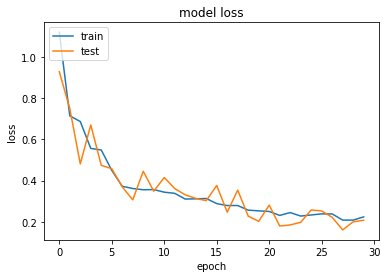

In [6]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

from keras.models import load_model

model1 = BuildModel_SegNet()
model1.load_weights('unet_best.h5')
# model1 = load_model('unet_best.h5')

In [7]:
from keras.models import load_model
# model1 = load_model('segnet_best.h5')
model1 = load_model('unet_best.h5')

In [8]:
for x, y in keras_generator(data.valid.image_paths, data.valid.masks_paths, 16):
    break

In [9]:
pred = model1.predict(x)

pred[:,:,:,2] *= 2

In [10]:
def getClassesMap(pred):
    res = np.zeros((pred.shape[0], pred.shape[1]), np.uint8)
    for r in range(pred.shape[0]):
        for c in range(pred.shape[1]):
            pred_class_index = np.argmax(pred[r,c,:])
            res[r,c] = pred_class_index
    res.shape
    return res

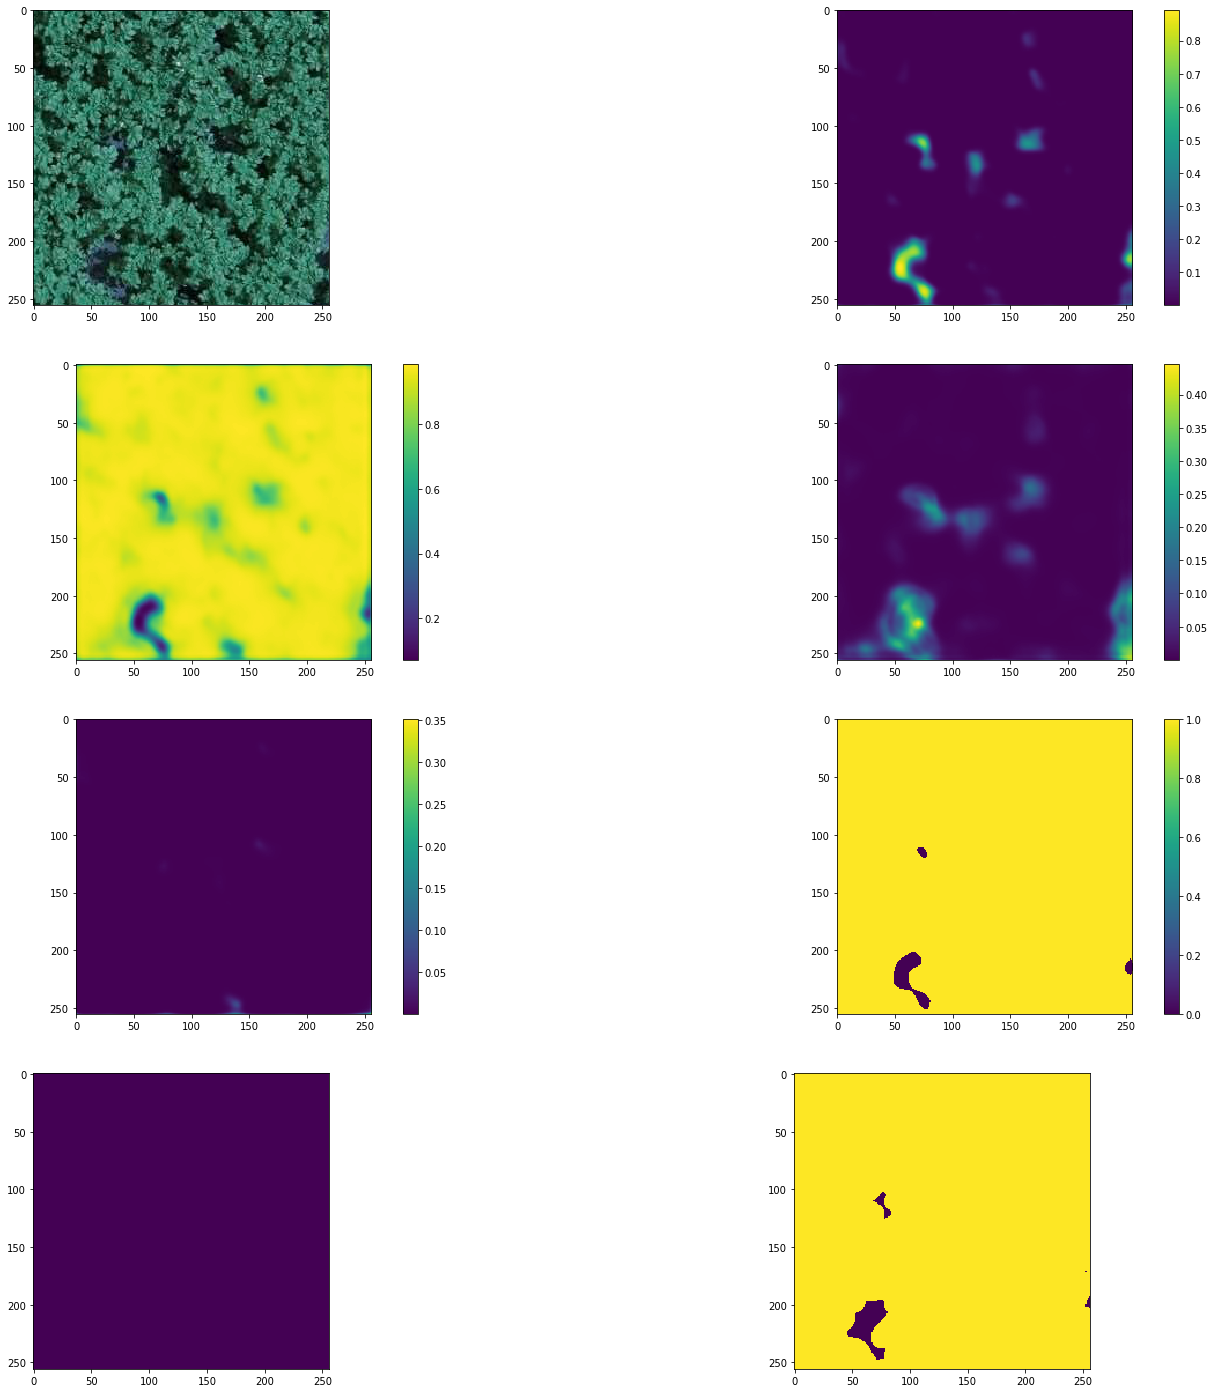

In [11]:
sample_index = 0
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 25))
axes[0][0].imshow(x[sample_index])
im_0_1 = axes[0][1].imshow(pred[sample_index, ..., 0])
im_1_0 = axes[1][0].imshow(pred[sample_index, ..., 1])
im_1_1 = axes[1][1].imshow(pred[sample_index, ..., 2])
im_2_0 = axes[2][0].imshow(pred[sample_index, ..., 3])
# im_2_1 = axes[2][1].imshow(keras.backend.eval(tf.keras.backend.argmax(pred[sample_index], 2)).astype(np.float32))
im_2_1 = axes[2][1].imshow(getClassesMap(pred[sample_index]))
# im_2_1 = axes[2][1].imshow(pred[sample_index, 20:40, 0:5, 0])
im_3_0 = axes[3][0].imshow(y[sample_index, ..., 2])
im_3_1 = axes[3][1].imshow(y[sample_index, ..., 1])

plt.colorbar(im_0_1, ax=axes[0,1])
plt.colorbar(im_1_0, ax=axes[1,0])
plt.colorbar(im_1_1, ax=axes[1,1])
plt.colorbar(im_2_0, ax=axes[2,0])
plt.colorbar(im_2_1, ax=axes[2,1])

plt.show()

In [12]:
def CountErrors(y, pred):
    ok_cnt = 0
    required = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
    }
    valid = {
        0: [0,0,0,0],
        1: [0,0,0,0],
        2: [0,0,0,0],
        3: [0,0,0,0],
    }
    errors = {
        0: [0,0,0,0],
        1: [0,0,0,0],
        2: [0,0,0,0],
        3: [0,0,0,0],
    }
    
    for r in range(y.shape[0]):
        for c in range(y.shape[1]):
            pred_class_index = np.argmax(pred[r,c,:])
            real_class_index = np.argmax(y[r,c,:])
            required[real_class_index] += 1
            if pred_class_index not in [0,1,2,3] or real_class_index not in [0,1,2,3]:
                print(r,c,pred_class_index, real_class_index)
                continue
#             print(r,c,pred_class_index, real_class_index)
            if pred_class_index == real_class_index:
                ok_cnt = ok_cnt + 1
                valid[real_class_index][pred_class_index] += 1
            else:
                errors[real_class_index][pred_class_index] += 1
    return ok_cnt, required, valid, errors

In [13]:
CountErrors(y[sample_index], pred[sample_index]) 

(64852,
 {0: 983, 1: 64553, 2: 0, 3: 0},
 {0: [519, 0, 0, 0], 1: [0, 64333, 0, 0], 2: [0, 0, 0, 0], 3: [0, 0, 0, 0]},
 {0: [0, 464, 0, 0], 1: [220, 0, 0, 0], 2: [0, 0, 0, 0], 3: [0, 0, 0, 0]})

In [14]:
sample_index = 2

ok_cnt, required, valid, errors = CountErrors(y[sample_index], pred[sample_index])       

In [15]:
ok_cnt, required, valid, errors

(52481,
 {0: 12488, 1: 32898, 2: 20150, 3: 0},
 {0: [9359, 0, 0, 0],
  1: [0, 30555, 0, 0],
  2: [0, 0, 12567, 0],
  3: [0, 0, 0, 0]},
 {0: [0, 2574, 555, 0],
  1: [129, 0, 2214, 0],
  2: [1222, 6361, 0, 0],
  3: [0, 0, 0, 0]})

In [16]:
sample_index = 5

ok_cnt, required, valid, errors = CountErrors(y[sample_index], pred[sample_index])   

In [17]:
ok_cnt, required, valid, errors

(63030,
 {0: 6977, 1: 57499, 2: 0, 3: 1060},
 {0: [5407, 0, 0, 0], 1: [0, 56751, 0, 0], 2: [0, 0, 0, 0], 3: [0, 0, 0, 872]},
 {0: [0, 1523, 39, 8],
  1: [387, 0, 309, 52],
  2: [0, 0, 0, 0],
  3: [0, 188, 0, 0]})

### Image by image segmentation

In [18]:
img_name = './validation/sample_1021.png'
mask_name = './validation/sample_1021_mask.png'
x,y = prepare_image_and_mask_for_prediction(img_name, mask_name)

In [19]:
pred = model1.predict(x)

for index in range(4):
    img = pred[0, ..., index] / np.max(pred[0, ..., index])
    img *= 255.0
    img = img.astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.imwrite('unet_{}.png'.format(index), img)
    
img = getClassesMap(pred[0]).astype(np.float32)
img = img / np.max(img)
img *= 255.0
img = img.astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.imwrite('unet_classes.png', img)

img = y[0].astype(np.float32)
img = y[0, ..., 0] * 0.0001 + y[0, ..., 1] * 1 + y[0, ..., 2] * 2 + y[0, ..., 3] * 3
img = img / np.max(img)
img *= 255.0
img = img.astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.imwrite('unet_gt.png', img)

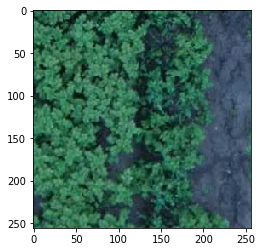

In [20]:
plt.imshow(x[0])

0.00024729967 0.990108


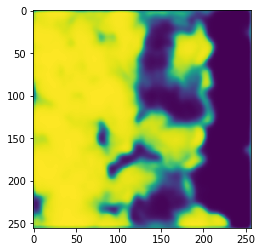

In [21]:
img = pred[0, ..., 1]
plt.imshow(img)
print(np.min(img), np.max(img))

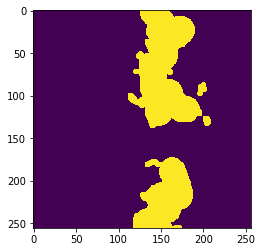

In [22]:
plt.imshow(y[0, ..., 2])

True

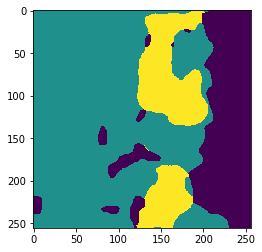

In [23]:
plt.imshow(getClassesMap(pred[0]))

img = (getClassesMap(pred[0]) * 255. / 3).astype(np.uint8)
img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
cv2.imwrite("sample_32_unet.png", img)

In [24]:
sum(sum(getClassesMap(pred)))

47470

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0,0].imshow(x[0])
im_0_1 = axes[0][1].imshow(pred[0, ..., 0])

plt.colorbar(im_0_1, ax=axes[0,1])

In [25]:
pred = model1.predict(x)

pred[:,:,:,2] *= 2

In [26]:
ok_cnt, required, valid, errors = CountErrors(y[0], pred[0]) 

In [27]:
ok_cnt, required, valid, errors

(58054,
 {0: 17253, 1: 37380, 2: 10903, 3: 0},
 {0: [14497, 0, 0, 0],
  1: [0, 34967, 0, 0],
  2: [0, 0, 8590, 0],
  3: [0, 0, 0, 0]},
 {0: [0, 2488, 268, 0],
  1: [1035, 0, 1378, 0],
  2: [248, 2065, 0, 0],
  3: [0, 0, 0, 0]})

### Estimate accuracy for validation set

In [28]:
all_ok_cnt = 0
all_required = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
}
all_valid = {
    0: [0,0,0,0],
    1: [0,0,0,0],
    2: [0,0,0,0],
    3: [0,0,0,0],
}
all_errors = {
    0: [0,0,0,0],
    1: [0,0,0,0],
    2: [0,0,0,0],
    3: [0,0,0,0],
}

for i in tqdm(range(len(data.valid.image_paths))):
    img_name = data.valid.image_paths[i]
    mask_name = data.valid.masks_paths[i]
    
    x,y = prepare_image_and_mask_for_prediction(img_name, mask_name)
    
    pred = model1.predict(x)
#     pred[:,:,:,2] *= 2
    
    ok_cnt, required, valid, errors = CountErrors(y[0], pred[0]) 
    
    all_ok_cnt += ok_cnt
    for j in range(4):
        all_required[j] = all_required[j] + required[j]
        all_valid[j] = [x + y for x, y in zip(all_valid[j], valid[j])]
        all_errors[j] = [x + y for x, y in zip(all_errors[j], errors[j])]

image_area = params.GetImageSize() * params.GetImageSize()
image_cnt = len(data.valid.image_paths)
scale = float(image_area * image_cnt) / 100.

all_ok_cnt /= scale
for j in range(4):
    all_required[j] /= scale
    all_valid[j] = [x / scale for x in all_valid[j]]
    all_errors[j] = [x / scale for x in all_errors[j]]

In [29]:
all_ok_cnt, all_required, all_valid, all_errors

(91.76171340942383,
 {0: 12.829752349853516,
  1: 77.62087554931641,
  2: 9.056103515625,
  3: 0.4932685852050781},
 {0: [10.526053619384765, 0.0, 0.0, 0.0],
  1: [0.0, 76.34297790527344, 0.0, 0.0],
  2: [0.0, 0.0, 4.453206634521484, 0.0],
  3: [0.0, 0.0, 0.0, 0.43947525024414064]},
 {0: [0.0, 2.0357200622558596, 0.23663787841796874, 0.03134078979492187],
  1: [0.48886795043945314, 0.0, 0.7557586669921875, 0.03327102661132812],
  2: [0.3448478698730469, 4.258049011230469, 0.0, 0.0],
  3: [0.014246368408203125, 0.039546966552734375, 0.0, 0.0]})

In [30]:
confusion_matrix = np.zeros([4,4])
for x in range(4):
    confusion_matrix[x,x] = all_valid[x][x]

for real_class in range(4):
    for predicted_class in range(4):
        if real_class == predicted_class:
            continue
        confusion_matrix[predicted_class,real_class] = all_errors[real_class][predicted_class]

precision = np.zeros([4])
for i in range(4):
    precision[i] = confusion_matrix[i,i] / sum(confusion_matrix[i,:])
    
recall = np.zeros([4])
for i in range(4):
    recall[i] = confusion_matrix[i,i] / sum(confusion_matrix[:,i])
        
def CalcF(precisionV, recallV):
    return 2 * precisionV * recallV / (precisionV + recallV)

F = [ CalcF(precisionV, recallV) for precisionV, recallV in zip(precision, recall) ]
F = np.array(F)

confusion_matrix, precision, recall, F
np.set_printoptions(precision=2)
np.set_printoptions(formatter={"float_kind": lambda x: "%0.2f" % x})

print("confusion_matrix = \n{}".format(confusion_matrix))
print("precision = {}".format(precision))
print("recall = {}".format(recall))
print("F = {}".format(F))

confusion_matrix = 
[[10.53 0.49 0.34 0.01]
 [2.04 76.34 4.26 0.04]
 [0.24 0.76 4.45 0.00]
 [0.03 0.03 0.00 0.44]]
precision = [0.93 0.92 0.82 0.87]
recall = [0.82 0.98 0.49 0.89]
F = [0.87 0.95 0.61 0.88]
